# 頑健な検出器：スケール不変性、回転不変性

資料
* https://news.mynavi.jp/article/computer_vision-29/
* https://www.slideshare.net/hironobufujiyoshi/miru2013sift
* http://www.mi.t.u-tokyo.ac.jp/harada/lectures/IIT/internal/04_detector_descriptor_20160511.pdf

## いろいろな検出器
* 回転不変: Hessian, Harris, SUSAN, LoG, SIFT, MSER, Hessian-Affine, SURF, FAST, ASIFT,KAZE, BRISK, AGAST
* スケール不変: DOG,　LoG,  SIFT, MSER, Hessian-Affine, SURF,  BRISK, ASIFT、KAZE
* アフィン不変: MSER, Hessian-Affine, ASIFT
* OpenCV実装: Harris, SIFT, MSER, SURF, FAST, BRISK, ORB, FREAK, KAZE

##  スケール不変なキーポイントの検出

### ラプラシアン・ガウシアンフィルタ

これまでで、Harrisの手法などのコーナー検出の方法を学んだ。これらの手法は回転不変であった。つまり、画像が回転していても、同じコーナーを見つけられる手法であった。画像が回転してもコーナーはコーナーのまま、というのは明らかである。しかし、スケール（拡大縮小）についてはどうであろうか。画像が拡大縮小されたら、コーナーはコーナーでなくなってしまわないだろうか。例えば下の画像を見てみよう。左の画像にある小さなウィンドゥの中のコーナーが右図のように拡大されている。ここで右図の画像を同じサイズのウィンドゥでつぎつぎ取り出して見ていくと、もはやコーナーはなくなっている。このことから明らかなように、Harrisの方法はスケール不変とはいえない。
![スケール不変性の必要性](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/sift_scale_invariant.jpg "コーナーの拡大")

今の例からわかるように、いろいろなスケールでキーポイントを検出するのは無理である。小さなコーナーなら大丈夫でも、大きなコーナーの検出には大きなウィンドゥでないとダメだったりする。そのため、スケール空間フィルタリングが使われる。

そこではいろいろな $\sigma$値に対しガウシアンフィルタで平滑化した後にラプラシアンフィルタを適用する(合わせてLoG (Laplacian of Gaussian) フィルタという)。

* ガウシアンフィルタ $G(x,y,\sigma)$: $\sigma$はケール、平滑化の範囲を決めるパラメタ（大きいほど平滑化される）

$G(x,y,\sigma) = \frac{1}{2\pi\sigma^2} \exp(-\frac{x^2+y^2}{2\sigma^2})$

* ガウシアンフィルタの適用

$\nabla^2(G(x,y,\sigma)*I(x,y)) = (\nabla^2G(x,y,\sigma))*I(x,y)$

* ラプラシアン・ガウシアンフィルタLoG

$LoG(x,y,\sigma) = \nabla^2(G(x,y,\sigma)) = -\frac{1}{\pi\sigma^4}(1-\frac{x^2+y^2}{2\sigma^2})\exp(-\frac{x^2+y^2}{2\sigma^2})$

このLoGフィルタは$\sigma$における変化からいろいろなサイズのしみ(ブロブ、blob)を検出するような働きをする. 要するに $\sigma$ はスケール・パラメータとして機能する。

例えば上の画像では、小さな $\sigma$をもつガウシアン・カーネルは小さなコーナーに対して大きな値を与え、大きな$\sigma$ をもつガウシアン・カーネルは大きなコーナーに適合する。それゆえ、 我々はいろいろなスケールと空間にわたって局所的極値を見つけることができる、つまり $(x,y,\sigma)$値---場所 $(x,y) $に $\sigma $ スケールでキーポイントの候補があることを意味するもの---のリストを得ることができる。

* 特徴的スケール

LoGを$x,y$を固定して$\sigma$の関数とみなし、これを$\sigma$で微分して局地を求める。このときの$\sigma$の値を特徴的スケールと呼ぶ
特徴的スケールに応じた大きさの局所領域を抽出できることから、スケール不変性がえられる


### ガウシアンフィルタの差分 DoG

LoGは計算コストが高い。そのため、近似としてガウシアンの差分(Difference of Gaussian, DoG)を用いる。DoGによってもスケール不変なブロブ検出が可能になる($k$はスケールにかける定数)

$DoG(x,y,\sigma) = G(x,y,k\sigma) - G(x,y,\sigma)$

これを$\sigma$で微分：<BR>
$\begin{array}{lcl} \frac{\partial G(x,y,\sigma)}{\partial \sigma} &=& \frac{x^2+y^2-2\sigma^2}{2\pi\sigma^5}\exp(-\frac{x^2+y^2}{2\sigma^2})\\
        & = & \sigma LoG(x,y,\sigma) \end{array}$

また以下のようにも表せる:<BR>
$\begin{array}{lcl} \frac{\partial G(x,y,\sigma)}{\partial \sigma} &=& \lim_{k \rightarrow 1} \frac{G(x,y,k\sigma)-G(x,y,k\sigma)}{(k-1)\sigma}\\
        & = & \frac{G(x,y,k_0\sigma)-G(x,y,k\sigma)}{(k_0-1)\sigma} \end{array}$
        
この２つを比較することで以下を得る:
$LoG(x,y,\sigma) \approx \frac{G(x,y,k_0\sigma)-G(x,y,k\sigma)}{(k_0-1)\sigma^2} = \frac{DoG(x,y,\sigma}{(k_0-1)\sigma^2}$

つまり、これから$LoG(x,y,\sigma)$が$DoG(x,y,\sigma)$で近似できることが示された。

DoGは異なる値の $\sigma$(それらを $\sigma$と $k\sigma$と表す)を用いて画像に対するガウシアンフィルタの値(平滑化)の差分から得られる。 この計算はガウシアン・ピラミッドにおける異なるオクターブに対して行われる。その過程を下の図で示す:

![DoG](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/sift_dog.jpg "DoG")

このDoGが得られたら、次にスケールと空間にわたって画像の局所的極値を探索する。これを次のイラストで示そう。例えば画像の１ピクセル（下図のXマーク）をその近隣の８ピクセル、および前後のスケール（図では上下)それぞれ９ピクセルと比較する。 もしもそれが局所的極値であれば、キーポイント候補である。基本的に、キーポイントはそのスケールで一番よく表されるということを意味する。

![Scale空間での探索](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/sift_local_extrema.jpg "Scale空間での探索")

# 回転やアフィン変形に頑健な検出器


アフィン変換によって記述できる変形をアフィン変形と呼ぶ。この変換は線形変換（回転、せん断、引張、圧縮など）と剛体変換（平行移動）によって構成される

## 回転不変性の確保

画像に写る対象物体が画像平面内で回転しても、同じ特徴として捉える回転不変な検出器を考える。
一般に、回転不変性の確保は、領域内の支配的な方向を発見し、この領域内の画像を支配的な方向に正規化することで実現

支配的な方向は、対象領域内の各画素の輝度勾配方向を求め、領域の最も頻度の高い方向とみなす

### 輝度勾配ヒストグラムの利用

輝度勾配ヒストグラムを利用した回転不変性の確保の手法はLowe(2004)によるもの

Lowe, D.G. (2004) <A HREF="https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf">Distinctive image features from scale-invariant keypoints</A>. <I>Int. Journal of Computer Vsion</I> 60(2). 91-110.

参考: http://www.mi.t.u-tokyo.ac.jp/harada/lectures/IIT/internal/04_detector_descriptor_20160511.pdf
1. スケール不変を備えた検出器でキーポイントの位置とスケールを推定
2. それぞれのキーポイント周辺の局所領域内の画素において、ガウス分布で重み付けされた輝度勾配の強度$w$と方向$\theta$を計算<BR>
    ![輝度勾配の計算]( Figs/B_Gradient.png "輝度勾配の計算")
    $\begin{array}{l}w(x,y) = G(x,y,\sigma)\sqrt{I^2_x + I^2_y}\\ \theta(x,y)=\tan^{-1}\frac{I_y}{I_x} \end{array}$
3. それぞれの画素の輝度勾配の方向を量子化し、ヒストグラムを作る。(下の例では360度を45度ずつ8方向に量子化)<BR>
    ![輝度勾配の量子化]( Figs/BG_Histo.png "輝度勾配の量子化")
    ![輝度勾配のブロック]( Figs/BG_Histo2.png "輝度勾配のブロック")
    ![輝度勾配ヒストグラム]( Figs/BG_Histo3.png "輝度勾配ヒストグラム")
4. 方向ヒストグラムがピークを示す（強度が最大のビンの）角度を、そのキーポイントにおける支配的な方向とみなす<BR>
輝度勾配を用いたキーポイントのベクトル表現。この図で最も大きな強度の方向が支配的な方向とみなす    
     ![輝度勾配によるベクトル表現]( Figs/BG_Description.png "輝度勾配によるベクトル表現")

### ボックスフィルタによる高速な計算方法

ボックスフィルタとは、例えばガウシアンフィルタの2次微分のカーネルを近似するフィルタによって高速に計算することを意図したフィルタ(近似カーネル)である。

輝度勾配を求めるボックスフィルタとして、ハールウェーブレット(Haar wevelet)を利用する。白い領域にある輝度の総和と黒い領域にある輝度の総和の差を計算することで、フィルタの応答が得られる。この計算は積分画像を利用することで効率的に実行できる。
（積分画像とは、原点$(0,0)$と$(x,y)$を対角の頂点とする長方形で囲まれる領域内の輝度値の和)

以下の左図を利用することで$x$方向の輝度勾配$d_x$、右図を利用することで$y$方向の輝度勾配$d_y$が得られる
![Haar Wavelet](Figs/Haar.png "Haar wavelet")

参考:http://www.mi.t.u-tokyo.ac.jp/harada/lectures/IIT/internal/04_detector_descriptor_20160511.pdf

ボックスフィルタを利用した輝度勾配の支配的な方向の求め方：
検出器を用いてキーポイントの位置とスケール$s$が求められたとする。キーポイント（特徴点）を中心とした局所領域(半径$6s$)に、$4s\times 4s$のボックスフィルタを適用し
<img src="Figs/HaarDominant.png" alt="ボックスフィルタの適用" title="ボックスフィルタの適用" width=30% />
一定のステップごと(ステップ幅$s$)にずらしながら$(d_x, d_y)$を求める。得られた局所領域の応答$(d_x,d_y)$を下図のように$d_xd_y$平面に描画する。ただしフィルタの応答はキーポイントを中心としたガウシアンフィルタで重み付けしておく。次に円弧の領域(この例では$\frac{\pi}{3}$)をずらしながら、その領域に含まれる点を加算することで、その円弧領域を代表するベクトルを計算する。そして最も大きなベクトルを、そのキーポイントにおける支配的な輝度勾配方向と判断する。
<img src="Figs/HaarDominant2.png" alt="応答の描画" title="応答の描画"  width=30% />


### パッチ内の画素値のモーメント

支配的な方向の求め方の簡易版として、パッチ内の画素値に関するモーメントを利用する方法がある(Rublee et al. 2011)

パッチ内の画素値に対して次式により0次モーメントと1次モーメントから重心$C$を計算

$\begin{array}{lcl} m_{pq} &= & \sum_{x,y}x^p y^q I(x,y)\\
                  C & = & \left(\frac{m_{10}}{m_{00}},\frac{m_{01}}{m_{11}}\right) \end{array}$
                  
パッチの中心$O$から重心$C$への方向を支配的な方向とする
<img src="Figs/UsingMoment.png" width=20% />

### アフィン変形に頑健な検出器

Wikipediaより: アフィン変換(affine transformation)によって記述できる変形をアフィン変形と呼ぶ。この変換は線形変換（回転、せん断、引張、圧縮など）と剛体変換（平行移動）によって構成される

アフィン変形に頑健な検出器の実現:
1. スケール不変の検出器を実行し、スケールに応じた円形領域を抽出する
2. 抽出した領域の2次モーメントの行列を求め、この行列の固有値を計算する。これにより局所のアフィン変換に対応する楕円形状が得られる。もしも得られた2つの固有値がほぼ同じ値なら手続きを終了
3. 楕円が円になるように特徴点周りの局所領域を変形する。変形後の画像において、スケール不変の検出器を実行し、位置とスケールを更新し、ステップ２に戻る

上記とは別の手法: MSER (maximally stable extremal regions)

1. 様々な閾値を用いてグレースケールの画像をバイナリ画像に変換し、画素同士が連結している領域(セグメント)を抽出する。
2. 閾値の変化に対して領域の面積変化が最も小さな領域を「最も安定した領域」と判定する。

このような安定領域は、様々な画像の変化に対しても安定であるため、アフィン変形に対しても頑健な領域と言える。
ただしこのセグメントは楕円形とは限らないため、楕円領域を得たい場合は、抽出した領域の２次モーメントの行列の固有ベクトルを計算して求める

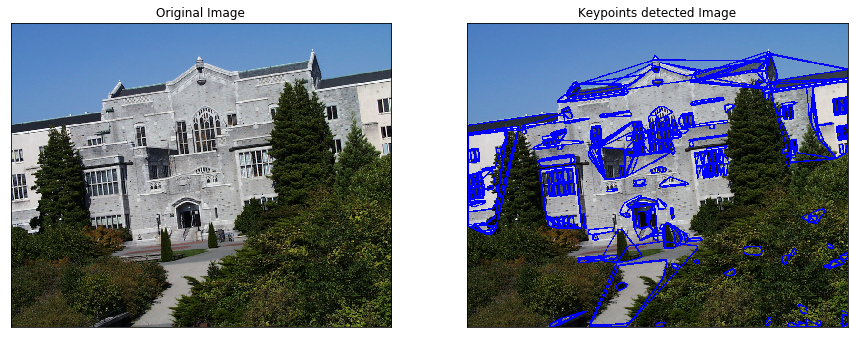

In [6]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Data/building.png')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mser = cv2.MSER_create()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
img2 = img.copy()

regions = mser.detectRegions(gray, None)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(img2, hulls, 1, (0, 0, 255), 2)

plt.figure(figsize=(15,13))
plt.subplot(121), plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2)
plt.title('Keypoints detected Image'), plt.xticks([]), plt.yticks([])
plt.show()